In [1]:
%load_ext autoreload
%autoreload 2
from tali_wit.data_plus import *
import numpy as np

/home/evolvingfungus/miniconda/envs/minimal-ml-template/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/evolvingfungus/miniconda/envs/minimal-ml-template/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
import torchvision

reader = torchvision.io.VideoReader(video_path, "video", device="cpu")

print(reader.get_metadata())
reader.seek(10, keyframes_only=True)
# frame = next(reader)

{
    'video': {'duration': [30.153], 'fps': [29.97002997002997]},
    'audio': {'duration': [30.0], 'framerate': [44100.0]},
    'subtitles': {'duration': []},
    'cc': {'duration': []}
}

In [48]:
import time

reader = torchvision.io.VideoReader(
    path=video_path, stream="video", device="cpu"
)
frame = next(reader)
frames = [frame]
timestamps = []
timestamp = 10
reader.seek(timestamp, keyframes_only=True)

cur_timestamp = timestamp
while cur_timestamp < 20:
    cur_timestamp = cur_timestamp + 0.2
    timestamps.append(cur_timestamp)

frame_dict = {}
starting_second = time.time()
# print(timestamps)
for t in timestamps:
    reader.seek(t, keyframes_only=True)
    frame = next(reader)
    frame_dict[frame["pts"]] = frame["data"]

end_time = time.time()
print(len(frame_dict))
print(f"total time: {end_time - starting_second}")

5

total time: 0.6238412857055664

In [80]:
import time

reader = torchvision.io.VideoReader(video_path, "audio", device="cpu")
reader.seek(10, keyframes_only=True)
timestamp = 10

frame_dict = {}
starting_second = time.time()

for frame in reader:
    if frame["pts"] > 20:
        break
    frame_dict[frame["pts"]] = frame["data"]
    # print(frame['data'].shape)

end_time = time.time()
print(len(frame_dict))
print(f"total time: {end_time - starting_second}")

482

total time: 0.01557779312133789

In [87]:
class FrameSelectioMethod:
    RANDOM: str = "random"
    UNIFORM: str = "uniform"
    SEQUENTIAL: str = "sequential"


def extract_frames(
    video_path,
    modality,
    start_time,
    end_time,
    num_frames,
    rng,
    frame_selection_method=FrameSelectioMethod.RANDOM,
):
    reader = torchvision.io.VideoReader(video_path, modality, device="cpu")
    reader.seek(start_time, keyframes_only=True)
    frame_dict = {}
    for frame in reader:
        if frame["pts"] > end_time:
            break
        frame_dict[frame["pts"]] = frame["data"]

    if frame_selection_method == FrameSelectioMethod.RANDOM:
        frame_indices = rng.choice(len(frame_dict), num_frames, replace=False)
    elif frame_selection_method == FrameSelectioMethod.UNIFORM:
        frame_indices = np.linspace(
            0, len(frame_dict), num_frames, endpoint=False, dtype=int
        )
    elif frame_selection_method == FrameSelectioMethod.SEQUENTIAL:
        frame_indices = np.arange(0, num_frames)

    frame_indices = sorted(frame_indices)

    frame_values = torch.stack(list(frame_dict.values()))

    return frame_values[frame_indices]

In [91]:
video_random = extract_frames(
    video_path,
    "video",
    10,
    20,
    30,
    np.random.RandomState(42),
    frame_selection_method=FrameSelectioMethod.RANDOM,
)
video_uniform = extract_frames(
    video_path,
    "video",
    10,
    20,
    30,
    np.random.RandomState(42),
    frame_selection_method=FrameSelectioMethod.UNIFORM,
)
video_sequential = extract_frames(
    video_path,
    "video",
    10,
    20,
    30,
    np.random.RandomState(42),
    frame_selection_method=FrameSelectioMethod.SEQUENTIAL,
)

In [90]:
print(
    f"random: {video_random.shape}, uniform: {video_uniform.shape}, sequential: {video_sequential.shape}"
)

random: torch.Size([30, 3, 360, 640]), uniform: torch.Size([30, 3, 360, 640]), sequential: torch.Size([30, 3, 360, 
640])

/tmp/ipykernel_1166/1165579699.py:2: TqdmExperimentalWarning: GUI is experimental/alpha
  with tqdm(total=100) as pbar:


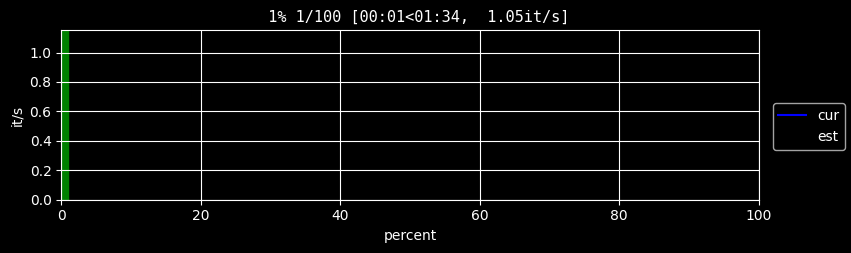

In [22]:
from tqdm import tqdm as tqdm

with tqdm(total=100) as pbar:
    for i in range(100):
        starting_second = np.random.randint(0, 30 - 10)
        ending_second = starting_second + 10
        output_dict = videoclip_to_video_audio_tensors(
            video_path=video_path,
            rng=np.random.RandomState(42),
            return_audio=True,
            return_video=True,
            return_image=True,
            starting_second=starting_second,
            ending_second=ending_second,
            num_audio_frames=16000 * 2,
            num_video_frames=16,
        )
        pbar.update(1)

In [14]:
print(output_dict.keys())
print(output_dict["audio"].shape)
print(output_dict["video"].shape)
print(output_dict["image"].shape)

dict_keys(['video', 'image', 'audio'])

torch.Size([32000])

torch.Size([16, 3, 224, 224])

torch.Size([3, 224, 224])